In [1]:
from scimath.units.length import meters as m
from scimath.units.length import kilometers as km
from scimath.units.length import light_year as ly
from scimath.units.mass import kilograms as kg
from scimath.units.time import seconds as s
from scimath.units.time import years as yr
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from src.constants import G, c, solar_mass, g
from src.utils import v_escape_solar
from src.engine import Engine
from src.starship import Starship
from src.solar_sail import SolarSail
%matplotlib inline

## Example: Simple Mission

This example mission has a single acceleration phase and a single deceleration phase at the destination

In [2]:
eng = {'main': Engine(1000.0 * kg)}
ss = Starship(1.0 * kg, eng)
ss.wait(10 * yr)
ti = ss.time
ss.accelerate(fuel_mass = 900 * kg)
t_accel = ss.time
ss.cruise(ss.destination_distance)
ss.accelerate(decelerate=True)
ss.wait(10 * yr)
ss.print_history()




{'time': 0.0*s, 'position': 0.0*m, 'velocity': 0.0*m*s**-1, 'fuel_mass': 1000.0*kg}

year 0.0 - Waited: 1.00e+01 years. Distance=0.00e+00 lightyears
{'time': 315576000.0*s, 'position': 0.0*m, 'velocity': 0.0*m*s**-1, 'fuel_mass': 1000.0*kg}

year 10.0 - Acceleration: 1.0 g for 9.65e-04 years.  New velocity is 9.96e-04 c.  1.00e+02 kg of fuel remaining.
{'time': 315636899.91823256*s, 'position': 4547916049.942738*m, 'velocity': 298714.09893052676*m*s**-1, 'fuel_mass': 100.0*kg}

year 10.0 - Cruise: 4.26e+03 years to complete. Distance=4.24e+00 lightyears
{'time': 134719202529.19725*s, 'position': 4.014824454791605e+16*m, 'velocity': 298714.09893052676*m*s**-1, 'fuel_mass': 100.0*kg}

year 4269.0 - Acceleration: 1.0 g for 9.65e-04 years.  New velocity is 0.00e+00 c.  5.46e+01 kg of fuel remaining.
{'time': 134719232979.15637*s, 'position': 4.01482490958321e+16*m, 'velocity': 0.0*m*s**-1, 'fuel_mass': 54.57271364317841*kg}

year 4269.0 - Waited: 1.00e+01 years. Distance=0.00e+00 lightye

<ipython-input-3-1c9e92bbb860>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


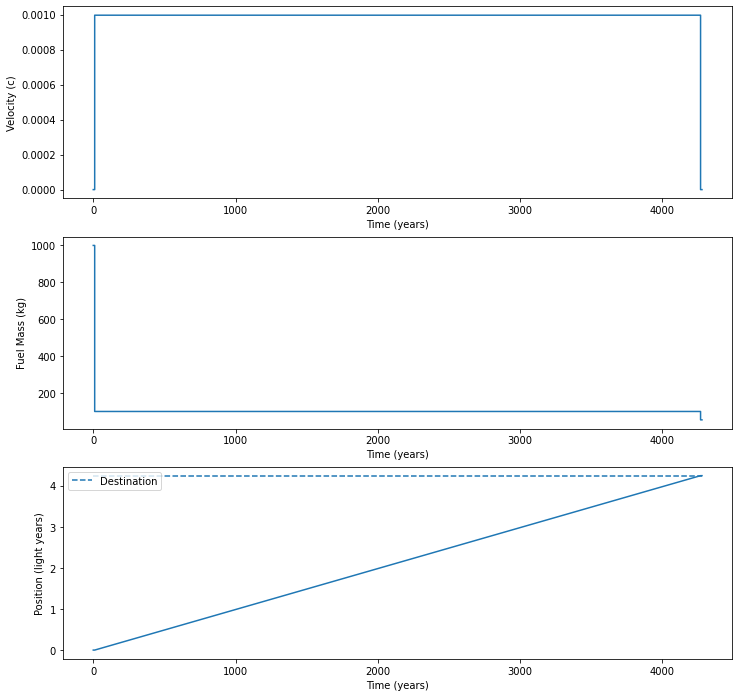

In [3]:
fig = ss.plot_history()
fig.show()

In [4]:
fig.savefig('../images/proxima_centauri.png')

## Example: Aborted mission

In this mission, the crew decides to abort the mission at the half-way point and return to the destination.

In [5]:
eng = {'main': Engine(1000.0 * kg)}
ss = Starship(1.0 * kg, eng)
ss.wait(10 * yr)
ss.accelerate(fuel_mass = 900 * kg)
ss.cruise(ss.destination_distance / 2)
ss.accelerate(decelerate=True)
ss.accelerate(fuel_mass = ss.fuel_mass(), decelerate=True)
ss.cruise(ss.destination_distance / 2)
ss.wait(10 * yr)
ss.print_history()



{'time': 0.0*s, 'position': 0.0*m, 'velocity': 0.0*m*s**-1, 'fuel_mass': 1000.0*kg}

year 0.0 - Waited: 1.00e+01 years. Distance=0.00e+00 lightyears
{'time': 315576000.0*s, 'position': 0.0*m, 'velocity': 0.0*m*s**-1, 'fuel_mass': 1000.0*kg}

year 10.0 - Acceleration: 1.0 g for 9.65e-04 years.  New velocity is 9.96e-04 c.  1.00e+02 kg of fuel remaining.
{'time': 315636899.91823256*s, 'position': 4547916049.942738*m, 'velocity': 298714.09893052676*m*s**-1, 'fuel_mass': 100.0*kg}

year 10.0 - Cruise: 2.13e+03 years to complete. Distance=2.12e+00 lightyears
{'time': 67517419714.55775*s, 'position': 2.007412454791605e+16*m, 'velocity': 298714.09893052676*m*s**-1, 'fuel_mass': 100.0*kg}

year 2139.5 - Acceleration: 1.0 g for 9.65e-04 years.  New velocity is 0.00e+00 c.  5.46e+01 kg of fuel remaining.
{'time': 67517450164.51686*s, 'position': 2.0074129095832096e+16*m, 'velocity': 0.0*m*s**-1, 'fuel_mass': 54.57271364317841*kg}

year 2139.5 - Acceleration: 1.0 g for 1.10e-03 years.  New velo

<ipython-input-6-1c9e92bbb860>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


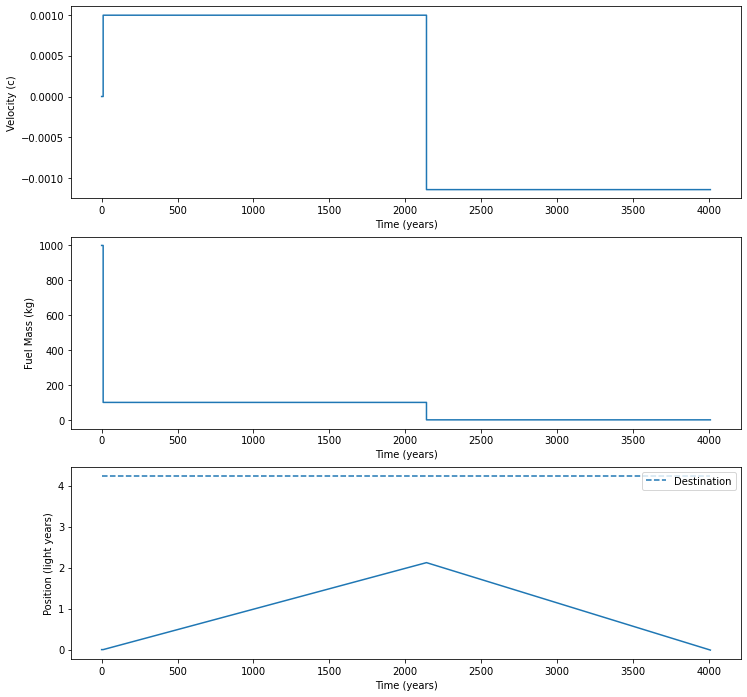

In [6]:
fig = ss.plot_history()
fig.show()

In [7]:
fig.savefig('../images/proxima_centauri_aborted.png')

# Example: Solar Sail And Rocket Mission

In [15]:
eng = {'main': Engine(1000.0 * kg)}
solar_sail = SolarSail(0.1 * kg, 1000.0 * m)
ss = Starship(1.0 * kg, eng, solar_sail=solar_sail, destination_distance=0.01 * ly)
ss.sail(None)
# ss.accelerate(fuel_mass = 900 * kg)
ss.cruise(ss.destination_distance - ss.position)
ss.accelerate(decelerate=True)
ss.wait(10 * yr)
ss.print_history()



{'time': 0.0*s, 'position': 0.0*m, 'velocity': 0.0*m*s**-1, 'fuel_mass': 1000.0*kg}

year 0.0 - Sailing with velocity 1.6028259640682596 m/s.
{'time': 60.0*s, 'position': 0.0*m, 'velocity': 1.6028259640682596*m*s**-1, 'fuel_mass': 1000.0*kg}

year 0.0 - Sailing with velocity 15697.97534493167 m/s.
{'time': 600060.0*s, 'position': 4758608298.252776*m, 'velocity': 15697.97534493167*m*s**-1, 'fuel_mass': 1000.0*kg}

year 0.0 - Sailing with velocity 29644.840098827957 m/s.
{'time': 1200060.0*s, 'position': 18479886473.312996*m, 'velocity': 29644.840098827957*m*s**-1, 'fuel_mass': 1000.0*kg}

year 0.1 - Sailing with velocity 40984.650793040964 m/s.
{'time': 1800060.0*s, 'position': 39803863500.15242*m, 'velocity': 40984.650793040964*m*s**-1, 'fuel_mass': 1000.0*kg}

year 0.1 - Sailing with velocity 49760.42242653652 m/s.
{'time': 2400060.0*s, 'position': 67145437532.66727*m, 'velocity': 49760.42242653652*m*s**-1, 'fuel_mass': 1000.0*kg}

year 0.1 - Sailing with velocity 56434.182966518245

<ipython-input-16-1c9e92bbb860>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


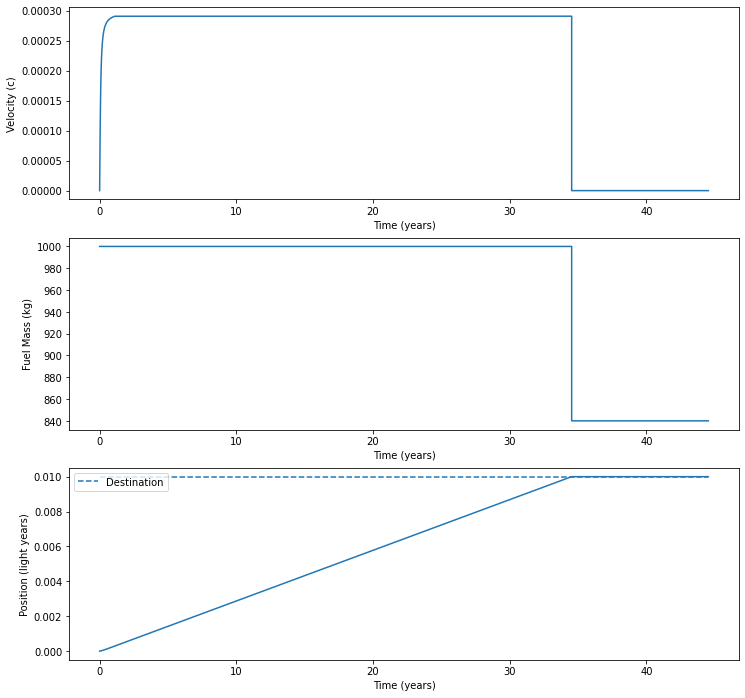

In [16]:
fig = ss.plot_history()
fig.show()